### Import Libraries

In [1]:
# import the necessary packages
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.models import Sequential
from keras.layers import Flatten, Dense, Lambda, Cropping2D, ELU, Dropout
from sklearn.model_selection import train_test_split
from keras.backend import tf as ktf
from keras.optimizers import Adam
from scipy.misc import imresize
from keras.callbacks import ModelCheckpoint
import csv
import matplotlib.image as mpimg
import cv2
import matplotlib.pyplot as plt
import random
from random import randint

Using TensorFlow backend.


### Function to read data

In [2]:
#read csv generated from the driving simulator
lines = []
with open('./data/data/driving_log.csv') as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
        lines.append(line)

In [3]:
def change_path_from_to(path, from_path="IMG",to_path="./data/data/IMG"):
    return path.replace(from_path, to_path)

### Function to load cropped images
The cropping is done to get rid of noise from the top and bottom , and resizing is done to match the input dimensions of the nvidia model

In [4]:
def load_image(imagepath):    
    im = mpimg.imread(imagepath, 1)
    return imresize(im[45:135, :], (66, 200, 3), interp='bilinear', mode=None)

### Function to flip images , this will be used for data augmentation

In [5]:
import numpy as np
def flip_image_and_steering(img, steering):
    return (np.fliplr(img), -steering)

### Function to augment more data with adjusted brightness

In [6]:
#random brightness    
def augment_brightness_camera_images(image):
    image1 = cv2.cvtColor(image,cv2.COLOR_RGB2HSV)
    image1 = np.array(image1, dtype = np.float64)
    random_bright = .5+np.random.uniform()
    image1[:,:,2] = image1[:,:,2]*random_bright
    image1[:,:,2][image1[:,:,2]>255]  = 255
    image1 = np.array(image1, dtype = np.uint8)
    image1 = cv2.cvtColor(image1,cv2.COLOR_HSV2RGB)
    return image1

### A sample image with transformations/preprocessing applied
1. Cropped to match the input dimension of nvidia architecture
2. Flipped to augment data
3. Changed brightness of some center images to augment more data


 Sample image:


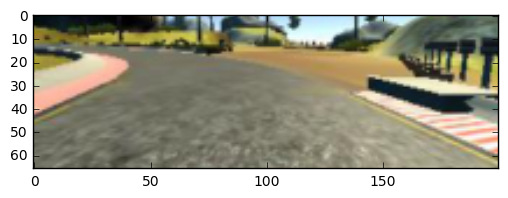


 Sample Image flipped


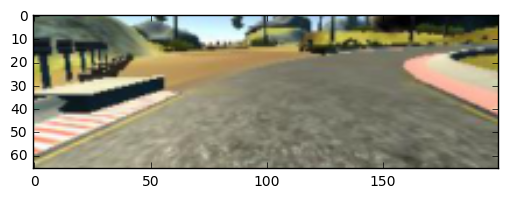


 Original image with brightness changed


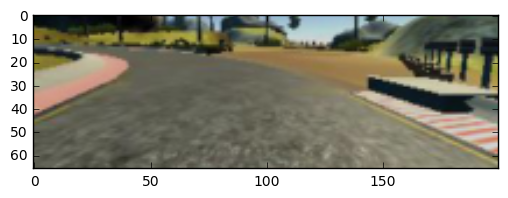

In [7]:
# read in images from center, left and right cameras
img_center = load_image(change_path_from_to(lines[20][0].strip()))
steering_center = float(lines[1232][3])
print("\n Sample image:")
plt.imshow(img_center)
plt.show()

print("\n Sample Image flipped")
img_center_flipped, steering_center_flipped = flip_image_and_steering(img_center, steering_center)
plt.imshow(img_center_flipped)
plt.show()


print("\n Original image with brightness changed")
plt.imshow(augment_brightness_camera_images(img_center))
plt.show()

In [8]:
#our X
car_images = []

#our Y - steering angle 
steering_angles = []

In [9]:
i = 0

for line in lines:
    if i == 0:
        i = i + 1
        continue
    
    #get corresponding streeing angle to Y
    steering_center = float(line[3])       
    
    # read in images from center, left and right cameras
    img_center = load_image(change_path_from_to(line[0].strip()))
    img_left = load_image(change_path_from_to(line[1].strip()))
    img_right = load_image(change_path_from_to(line[2].strip()))    

   
    # create adjusted steering measurements for the side camera images
    correction = 0.20 # this is a parameter to tune
    steering_left = steering_center + correction
    steering_right = steering_center - correction    
    
   
    #lets start augmenting data for these set of images

    #flip the center , left and right images and add to the augmented list 
    img_center_flipped, steering_center_flipped = flip_image_and_steering(img_center, steering_center)
    img_left_flipped, steering_left_flipped = flip_image_and_steering(img_left, steering_left)
    img_right_flipped, steering_right_flipped = flip_image_and_steering(img_right, steering_right)


    #finally add to the final list 
    car_images.extend( [img_center, img_left, img_right, img_center_flipped, img_left_flipped, img_right_flipped, 
                          augment_brightness_camera_images(img_center)])
    steering_angles.extend([steering_center, steering_left, steering_right, 
                                   steering_center_flipped, steering_left_flipped, steering_right_flipped, steering_center])

In [10]:
len(car_images)

56252

In [11]:
len(steering_angles)

56252

### We ended with a little over double the input count of images using data augmentataion 

In [12]:
#crop images to match the 66x208 nvidia architecture input
#keras needs us to convert to numpy arrays
# X_train = np.array(list(map(resize_img, car_images)))
# train_samples, validation_samples, train_labels, validation_labels = train_test_split(car_images, steering_angles, test_size=0.2, random_state=42)

# resized_car_images = []
# for i in car_images:
#     resized_car_images.append(resize_img(i))

X_train = np.array(car_images)
y_train = np.array(steering_angles)

del car_images
# del resized_car_images
del steering_angles

** Note: I tried using generators, but that reduced the speed of training significantly, and I had to stop using generators.**

In [13]:
# import sklearn
# from sklearn.utils import shuffle
# def generator(samples, labels, batch_size=5000):
#     num_samples = len(samples)
#     while 1: # Loop forever so the generator never terminates
#         X, y = shuffle(samples, labels)
#         for offset in range(0, num_samples, batch_size):
#             batch_samples = X[offset:offset+batch_size]
#             batch_labels = y[offset:offset+batch_size]

#             images = []
#             angles = []
          
#             for batch_sample, batch_label in zip(batch_samples, batch_labels):
#                 images.append(resize_img(batch_sample))
#                 angles.append(batch_label)

#             # trim image to only see section with road
#             X_train = np.array(images)
#             y_train = np.array(angles)
#             yield sklearn.utils.shuffle(X_train, y_train)

# # compile and train the model using the generator function
# train_generator = generator(train_samples, train_labels, batch_size=32)
# validation_generator = generator(validation_samples, validation_labels, batch_size=32)

### Model architecture

In [14]:
class nvidia_model:
    #http://www.pyimagesearch.com/2016/08/01/lenet-convolutional-neural-network-in-python/
    @staticmethod
    def build(width=200, height=66, depth=3):
        """
        width: The width of our input images.
        height: The height of our input images.
        depth: The depth (i.e., number of channels) of our input images.
        """
        
        # initialize the model
        model = Sequential()
        #preprocessing step - 1
        # divide by max value i.e. 255 to bring values between 0 and 1
        #subtract 0.5 to center around 0        
        model.add(Lambda(lambda x:x / 255 - 0.5, input_shape=(height, width, depth)))
                          
        #add 3 layers of conv2d , (output depth 24, 36, and 48), each with 2x2 stride
        model.add(Conv2D(24, (5, 5), activation="elu",  kernel_initializer="he_normal", strides=(2,2), padding='valid'))
        model.add(Conv2D(36, (5, 5), activation="elu",  kernel_initializer="he_normal", strides=(2,2), padding='valid'))
        model.add(Conv2D(48, (5, 5), activation="elu",  kernel_initializer="he_normal", strides=(2,2), padding='valid'))
        model.add(Conv2D(64, (3, 3), activation="elu",  kernel_initializer="he_normal", strides=(1,1), padding='valid'))
        model.add(Conv2D(64, (3, 3), activation="elu",  kernel_initializer="he_normal", strides=(1,1), padding='valid'))
        model.add(Flatten())
        model.add(Dense(100, kernel_initializer='he_normal'))
        model.add(ELU())
        model.add(Dense(50, kernel_initializer='he_normal'))
        model.add(ELU())
        model.add(Dense(10, kernel_initializer='he_normal'))
        model.add(ELU())
        model.add(Dense(1, kernel_initializer='he_normal'))
                  
        # return the constructed network architecture
        return model        

### Training and model saving after each iteration

In [15]:
model = nvidia_model.build()


# checkpoint
checkpoint = ModelCheckpoint("model-{epoch:02d}.h5", monitor='loss', verbose=1, save_best_only=False, mode='max')

# model.compile(loss='mse', optimizer='adam')
adam = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model.compile(optimizer=adam, loss='mse')    
model.fit(X_train, y_train, validation_split=0.2, shuffle=True, epochs=7, callbacks=[checkpoint])

Train on 45001 samples, validate on 11251 samples
Epoch 1/7
45001/45001 [==============================] - 459s - loss: 0.0240 - val_loss: 0.0197
Epoch 2/7
45001/45001 [==============================] - 477s - loss: 0.0150 - val_loss: 0.0206
Epoch 3/7
45001/45001 [==============================] - 481s - loss: 0.0128 - val_loss: 0.0197
Epoch 4/7
45001/45001 [==============================] - 466s - loss: 0.0114 - val_loss: 0.0217
Epoch 5/7
45001/45001 [==============================] - 464s - loss: 0.0102 - val_loss: 0.0210
Epoch 6/7
45001/45001 [==============================] - 464s - loss: 0.0091 - val_loss: 0.0216
Epoch 7/7
45001/45001 [==============================] - 474s - loss: 0.0082 - val_loss: 0.0213
